# EVN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

# 단어 긍정(2), 중립(1), 부정(0) 분류 프로젝트

## 데이터

In [2]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아',
    '나는 오늘 우울해'
]

# 출력 정답
labels = [[1, 1, 1, 2],
          [1, 1, 0]]  # 긍정(2), 중립(1), 부정(0)

# 정답 dic
id_to_label = {0: '부정', 1: '중립', 2: '긍정'}

## Vocabulary

In [3]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())
words

['나는', '오늘', '기분이', '좋아', '나는', '오늘', '우울해']

In [4]:
# 중복 단어 제거
words = list(dict.fromkeys(words))
words

['나는', '오늘', '기분이', '좋아', '우울해']

In [5]:
# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)
word_to_id

{'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5}

In [6]:
# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}
id_to_word

{0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'}

## 모델 학습용 데이터 생성

In [7]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
    train_inputs.append([word_to_id[word] for word in sentence.split()])
train_inputs

[[2, 3, 4, 5], [2, 3, 6]]

In [8]:
# train label은 labels를 그래도 사용
train_labels = labels
train_labels

[[1, 1, 1, 2], [1, 1, 0]]

In [9]:
# train inputs을 numpy array로 변환
np.array(train_inputs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


array([list([2, 3, 4, 5]), list([2, 3, 6])], dtype=object)

In [10]:
# train labels을 numpy array로 변환
np.array(train_labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


array([list([1, 1, 1, 2]), list([1, 1, 0])], dtype=object)

In [11]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_inputs:
    row += [0] * (4 - len(row))
train_inputs

[[2, 3, 4, 5], [2, 3, 6, 0]]

In [12]:
# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)
train_inputs

array([[2, 3, 4, 5],
       [2, 3, 6, 0]])

In [13]:
# 정답 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_labels:
    row += [1] * (4 - len(row))
train_labels

[[1, 1, 1, 2], [1, 1, 0, 1]]

In [14]:
# 학습용 정답을 numpy array로 변환
train_labels = np.array(train_labels)
train_labels

array([[1, 1, 1, 2],
       [1, 1, 0, 1]])

## 모델링

In [ ]:
# 입력 단어를 vector로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id), 8)
hidden = embedding(train_inputs)
hidden

In [ ]:
# embedding weight
weight = embedding.get_weights()[0]
weight

In [ ]:
# numpy를 이용해서 직접 조회 (두 결과값 비교)
weight[train_inputs], hidden

In [ ]:
# 단어의 vector를 이용해서 긍정(2), 부정(0), 중립(1) 확률값 예측
linear = tf.keras.layers.Dense(3, activation=tf.nn.softmax)
outputs = linear(hidden)
outputs

In [ ]:
# dense의 wieght, bias
weight, bias = linear.get_weights()
weight, bias

In [ ]:
# numpy를 이용한 xW + b
logits = np.matmul(hidden, weight) + bias
logits

In [ ]:
# softmax 계산을 위한 준비 exp(x') / sum(exp(x))
numerator = np.exp(logits)
denominator = np.sum(numerator, axis=2, keepdims=True)
numerator, denominator

In [ ]:
# 두 결과값 비교
probs = numerator / denominator
probs, outputs

In [47]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    동작만 하는 간단한 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    inputs = tf.keras.layers.Input((n_seq,))  # (bs, n_seq)
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden = embedding(inputs)  # (bs, n_seq, d_model)
    #######################################
    conv_1 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='causal')
    hidden = conv_1(hidden)

    hidden = tf.keras.layers.SimpleRNN(units = 128, return_sequences= True)(hidden)
    hidden = tf.keras.layers.SimpleRNN(units = 256, return_sequences= True)(hidden)
    # 여기에 CNN 및 RNN 모델을 추가해 보세요.
    #######################################
    # 단어의 vector를 이용해서 정답 확률값 예측
    linear = tf.keras.layers.Dense(n_out, activation=tf.nn.softmax)
    outputs = linear(hidden)  # (bs, n_seq, n_out)
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

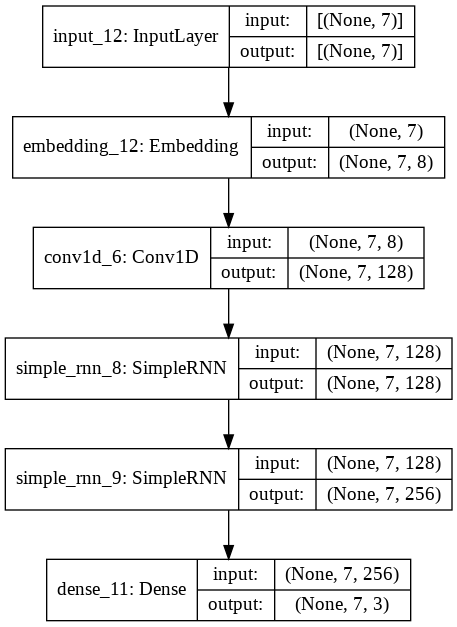

In [48]:
# 모델 생성
model = build_model(len(word_to_id), 8,7, 3)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

## 학습

In [33]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit(train_inputs, train_labels, epochs=100, batch_size=16)

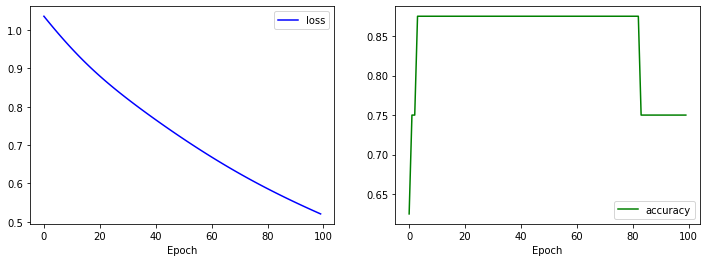

In [46]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 평가

In [ ]:
# 모델 평가
model.evaluate(train_inputs, train_labels)

1/1 [==============================] - 0s 160ms/step - loss: 0.7894 - accuracy: 1.0000


[0.7894403338432312, 1.0]

## 예측

In [ ]:
# 추론할 입력
string = '나는 기분이 우울해'

In [ ]:
# 입력을 숫자로 변경
infer_input = [word_to_id[word] for word in string.split()]
infer_input

[2, 4, 6]

In [ ]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
infer_input += [0] * (4 - len(infer_input))
infer_input

[2, 4, 6, 0]

In [ ]:
# numpy array 변환 (batch size 1 추가)
infer_inputs = np.array([infer_input])
infer_inputs

array([[2, 4, 6, 0]])

In [ ]:
# 긍정/부정 추론
y_preds = model.predict(infer_inputs)
y_preds

array([[[0.2415011 , 0.48354098, 0.27495804],
        [0.25020355, 0.4787556 , 0.27104086],
        [0.4021103 , 0.33205727, 0.26583245],
        [0.24014741, 0.48747635, 0.27237633]]], dtype=float32)

In [ ]:
# 확률의 max 값을 추론 값으로 결정
y_pred_class = np.argmax(y_preds, axis=2)
y_pred_class

array([[1, 1, 0, 1]])

In [ ]:
# 각 예측 값에 대한 label string
for row in y_pred_class:
    for val in row:
        print(val, ':', id_to_label[val])

1 : 중립
1 : 중립
0 : 부정
1 : 중립


# 문장 긍정(1), 부정(0) 분류 프로젝트

## 데이터

In [ ]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아',
    '나는 오늘 우울해'
]

# 출력 정답
labels = [1, 0]  # 긍정(1), 부정(0)

# 정답 dic
id_to_label = {0: '부정', 1: '긍정'}

## Vocabulary

In [ ]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())
words

['나는', '오늘', '기분이', '좋아', '나는', '오늘', '우울해']

In [ ]:
# 중복 단어 제거
words = list(dict.fromkeys(words))
words

['나는', '오늘', '기분이', '좋아', '우울해']

In [ ]:
# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)
word_to_id

{'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5}

In [ ]:
# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}
id_to_word

{0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'}

## 모델 학습용 데이터 생성

In [ ]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
    train_inputs.append([word_to_id[word] for word in sentence.split()])
train_inputs

[[2, 3, 4, 5], [2, 3, 6]]

In [ ]:
# train label은 labels를 그래도 사용
train_labels = labels
train_labels

[1, 0]

In [ ]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_inputs:
    row += [0] * (4 - len(row))
train_inputs

[[2, 3, 4, 5], [2, 3, 6, 0]]

In [ ]:
# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)
train_inputs

array([[2, 3, 4, 5],
       [2, 3, 6, 0]])

In [ ]:
# 학습용 정답을 numpy array로 변환
train_labels = np.array(train_labels)
train_labels

array([1, 0])

## 모델링

In [ ]:
# 입력 단어를 vector로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id), 8)
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(2, 4, 8), dtype=float32, numpy=
array([[[-0.00182004,  0.0279287 ,  0.044409  ,  0.0277856 ,
          0.01629411, -0.00190259, -0.01957138,  0.00628724],
        [-0.01373566, -0.04990305,  0.03305267, -0.02266804,
         -0.00296776,  0.01482472,  0.00950866, -0.04049486],
        [ 0.01246595,  0.01390983, -0.04552514,  0.04331896,
          0.02931431,  0.04798057,  0.02834884,  0.02483625],
        [ 0.02481509, -0.04555463, -0.01787534,  0.01314366,
          0.04568162,  0.03934005,  0.00249149,  0.0301929 ]],

       [[-0.00182004,  0.0279287 ,  0.044409  ,  0.0277856 ,
          0.01629411, -0.00190259, -0.01957138,  0.00628724],
        [-0.01373566, -0.04990305,  0.03305267, -0.02266804,
         -0.00296776,  0.01482472,  0.00950866, -0.04049486],
        [-0.01947755,  0.01228499,  0.00922554, -0.03391924,
         -0.00093282,  0.01821012,  0.02856246, -0.01933612],
        [-0.01266861, -0.00808046,  0.04329977,  0.02481422,
         -0.04159075,  0.

In [ ]:
# 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
pool = tf.keras.layers.GlobalMaxPool1D()
hidden_pool = pool(hidden)
hidden_pool

<tf.Tensor: shape=(2, 8), dtype=float32, numpy=
array([[ 0.02481509,  0.0279287 ,  0.044409  ,  0.04331896,  0.04568162,
         0.04798057,  0.02834884,  0.0301929 ],
       [-0.00182004,  0.0279287 ,  0.044409  ,  0.0277856 ,  0.01629411,
         0.03699004,  0.02856246,  0.00628724]], dtype=float32)>

In [ ]:
# 문장 vector를 이용해서 긍정(1), 부정(0) 확률값 예측
linear = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
outputs = linear(hidden_pool)
outputs

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.49706075, 0.5029392 ],
       [0.50607586, 0.4939241 ]], dtype=float32)>

In [ ]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    동작만 하는 간단한 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    inputs = tf.keras.layers.Input((n_seq,))  # (bs, n_seq)
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden = embedding(inputs)  # (bs, n_seq, d_model)
    #######################################
    # 여기에 CNN 및 RNN 모델을 추가해 보세요.
    #######################################
    # 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
    pool = tf.keras.layers.GlobalMaxPool1D()
    hidden_pool = pool(hidden)  # (bs, d_model)
    # 문장 vector를 이용해서 긍정(1), 부정(0) 확률값 예측
    linear = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    outputs = linear(hidden_pool)  # (bs, n_out)
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

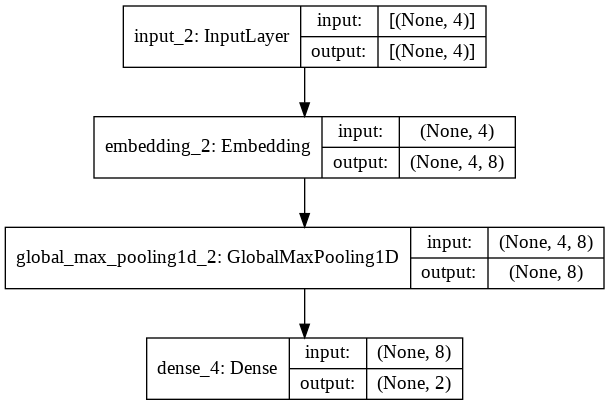

In [ ]:
# 모델 생성
model = build_model(len(word_to_id), 8, 4, 2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

## 학습

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit(train_inputs, train_labels, epochs=20, batch_size=16)

Epoch 1/20
1/1 [==============================] - 0s 377ms/step - loss: 0.6953 - accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 1.0000
Epoch 8/20
1/1 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 1.0000
Epoch 9/20
1/1 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 1.0000
Epoch 10/20
1/1 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 1.0000
Epoch 11/20
1/1 [====================

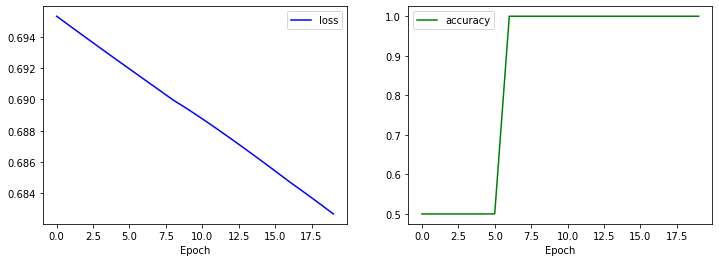

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 평가

In [ ]:
# 모델 평가
model.evaluate(train_inputs, train_labels)

1/1 [==============================] - 0s 129ms/step - loss: 0.6820 - accuracy: 1.0000


[0.6819601058959961, 1.0]

## 예측

In [ ]:
# 추론할 입력
string = '나는 기분이 우울해'

In [ ]:
# 입력을 숫자로 변경
infer_input = [word_to_id[word] for word in string.split()]
infer_input

[2, 4, 6]

In [ ]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
infer_input += [0] * (4 - len(infer_input))
infer_input

[2, 4, 6, 0]

In [ ]:
# numpy array 변환 (batch size 1 추가)
infer_inputs = np.array([infer_input])
infer_inputs

array([[2, 4, 6, 0]])

In [ ]:
# 긍정/부정 추론
y_preds = model.predict(infer_inputs)
y_preds

array([[0.51252794, 0.48747206]], dtype=float32)

In [ ]:
# 확률의 max 값을 추론 값으로 결정
y_pred_class = np.argmax(y_preds, axis=1)
y_pred_class

array([0])

In [ ]:
# 각 예측 값에 대한 label string
for val in y_pred_class:
    print(val, ':', id_to_label[val])

0 : 부정
